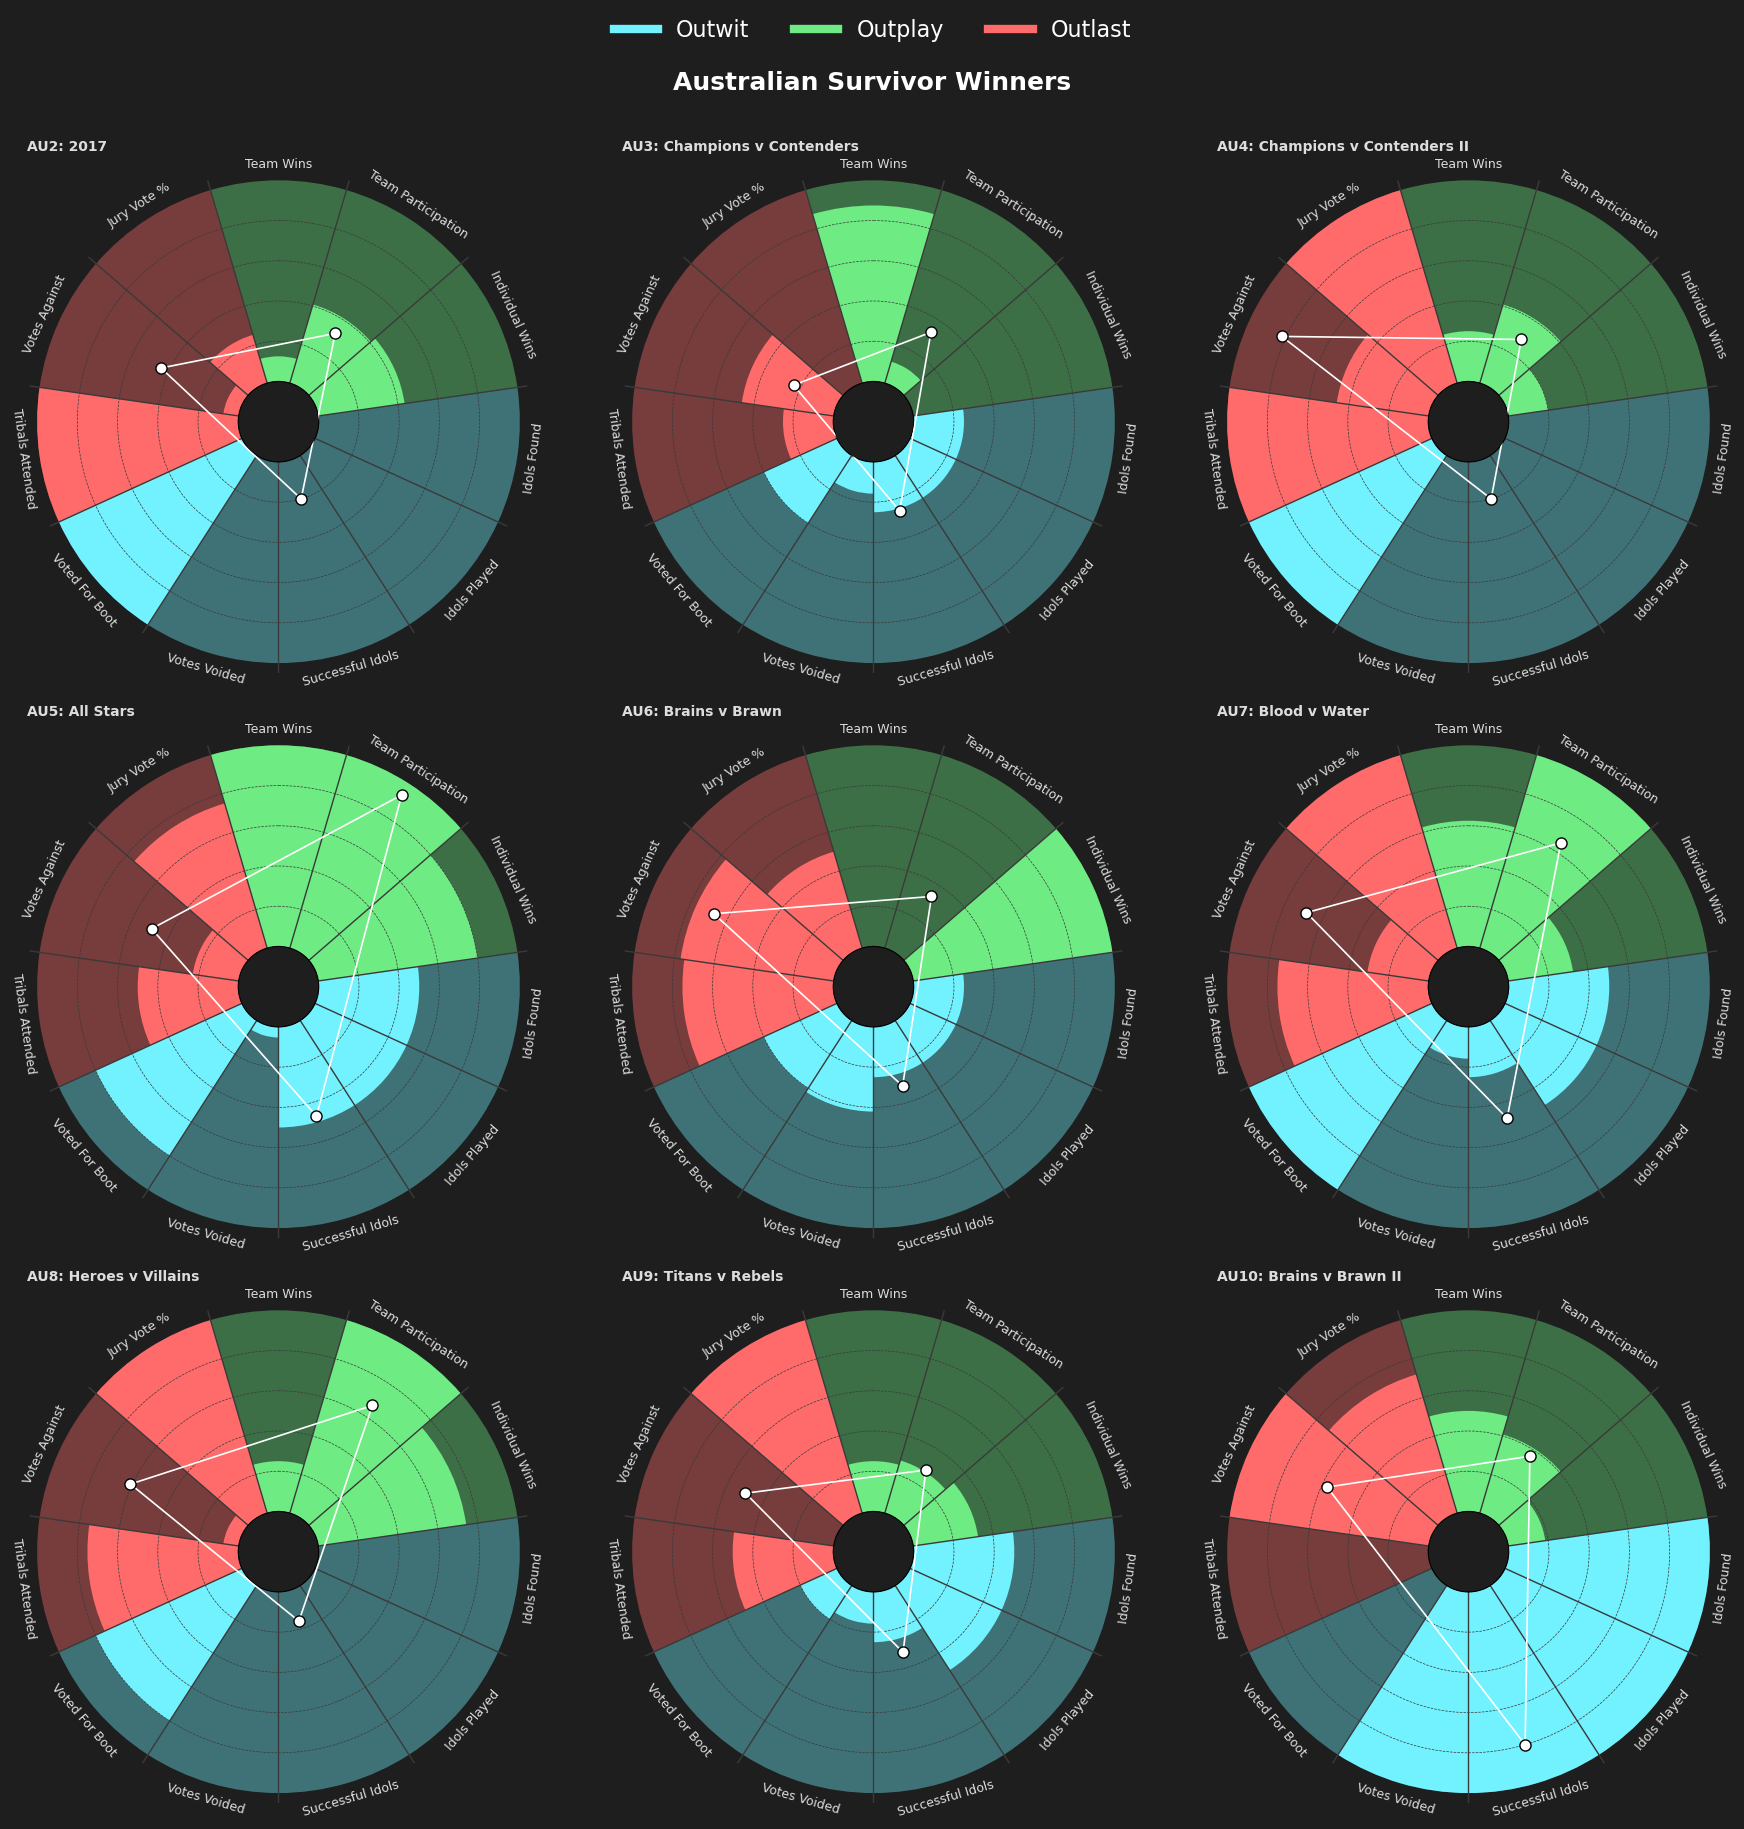

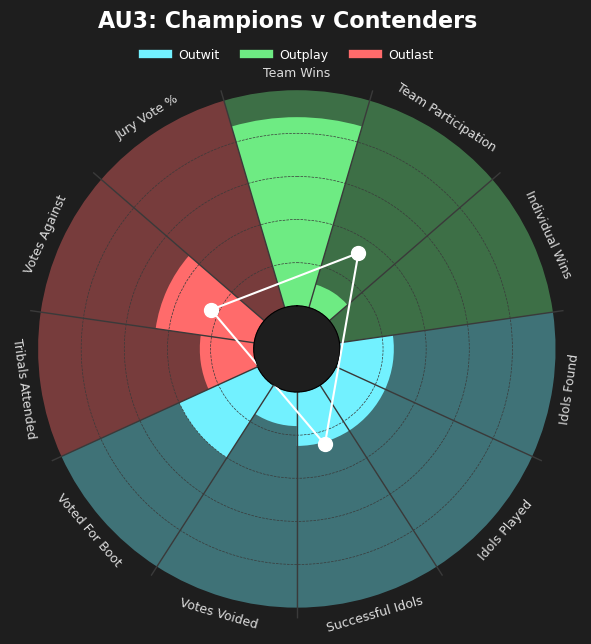

'\nJericho Malabonga\nShane Gould\nPia Miranda\nDavid Genat\nHayley Leake\nMark Wales\nLiz Parnov\nFeras Basal\nMyles Kuah\n'

In [2]:
# ================================
# Imports
# ================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from mplsoccer import PyPizza
import matplotlib.pyplot as plt

# ================================
# Step 1: Load Data
# ================================
df = pd.read_csv("data.csv")

# ================================
# Step 2: Define Metrics & Categories
# ================================
metric_categories = {
    "Team Challenges Won": "Outplay",
    "Team Challenges Played": "Outplay",
    "Ind Challenges Won": "Outplay",
    "Idols Found": "Outwit",
    "Idols Played": "Outwit",
    "Succesful Idols Played": "Outwit",
    "Votes Voided": "Outwit",
    "VFB": "Outwit",
    "Tribals": "Outlast",
    "VAP": "Outlast",
    "Jury Votes Received": "Outlast",
}

# ================================
# Step 3: Derived Metrics
# ================================
df["Ind Challenge Win Rate"] = df["Ind Challenges Won"] / df["Ind Challenges Played"].replace(0, 1)
df["Jury Vote %"] = df["Jury Votes Received"] / df["Total Jurors"].replace(0, 1)
team_total = df["Team Challenges Played"] + df["Team Challenges Sat Out"]
df["Team Challenge Participation"] = df["Team Challenges Played"] / team_total.replace(0, 1)

df.fillna({
    "Team Challenge Participation": 0,
    "Jury Vote %": 0,
    "Ind Challenge Win Rate": 0
}, inplace=True)

# ================================
# Step 4: Normalize
# ================================
refined_metrics = [
    "Team Challenges Won",
    "Team Challenge Participation",
    "Ind Challenge Win Rate",
    "Idols Found",
    "Idols Played",
    "Succesful Idols Played",
    "Votes Voided",
    "VFB",
    "Tribals",
    "VAP",
    "Jury Vote %"
]

# Add derived metrics to categories
metric_categories.update({
    "Team Challenge Participation": "Outplay",
    "Ind Challenge Win Rate": "Outplay",
    "Jury Vote %": "Outlast"
})

# Scale metrics
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[refined_metrics]), columns=refined_metrics)
df_scaled["Sole Survivor"] = df["Sole Survivor"]

# ================================
# Step 5: Melt and Label
# ================================
df_melted = df_scaled.melt(
    id_vars="Sole Survivor",
    var_name="Metric",
    value_name="Normalized Score"
)
df_melted["Category"] = df_melted["Metric"].map(metric_categories)

metric_aliases = {
    "Team Challenges Won": "Team Wins",
    "Team Challenge Participation": "Team Participation",
    "Ind Challenge Win Rate": "Individual Wins",
    "Idols Found": "Idols Found",
    "Idols Played": "Idols Played",
    "Succesful Idols Played": "Successful Idols",
    "Votes Voided": "Votes Voided",
    "VFB": "Voted For Boot",
    "Tribals": "Tribals Attended",
    "VAP": "Votes Against",
    "Jury Vote %": "Jury Vote %"
}

# ================================
# Step 6: Plot Single Pizza Chart
# ================================
def plot_pizza(survivor_name, title_by="Season"):
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': 'polar'})
    fig.patch.set_facecolor('#1E1E1E')

    data = df_melted[df_melted["Sole Survivor"] == survivor_name]
    params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
    values = (data["Normalized Score"] * 100).tolist()
    categories = data["Category"].tolist()

    color_map = {
        "Outwit": "#72F1FF",
        "Outplay": "#6EEB83",
        "Outlast": "#FF6B6B"
    }
    slice_colors = [color_map[cat] for cat in categories]

    baker = PyPizza(
        params=params,
        background_color="#1E1E1E",
        straight_line_color="#3A3A3A",
        other_circle_color="#3A3A3A",
        straight_line_lw=1,
        last_circle_lw=0,
        other_circle_lw=0.5,
        inner_circle_size=20,
        max_range=100,
    )

    baker.make_pizza(
        values,
        ax=ax,
        slice_colors=slice_colors,
        value_bck_colors=slice_colors,
        figsize=(7, 7),
        kwargs_values={"fontsize": 0, "color": "none", "visible": False},
        color_blank_space="same",
        value_colors=slice_colors,
        blank_alpha=0.4,
        kwargs_params=dict(color="#DDDDDD", fontsize=9, va="center")
    )

    title_text = df.loc[df["Sole Survivor"] == survivor_name, "Season"].values[0] if title_by.lower() == "season" else survivor_name
    title_fontsize = 16 if title_by.lower() == "season" else 20
    plt.suptitle(title_text, fontsize=title_fontsize, y=0.98, fontweight="bold", color="#FFFFFF")

    handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat) for cat in color_map]
    fig.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.94),
        ncol=3,
        frameon=False,
        fontsize=9,
        labelcolor="#FFFFFF",
        bbox_transform=fig.transFigure
    )

    subset = df_scaled[df_scaled["Sole Survivor"] == survivor_name]
    outwit = subset[["Idols Found", "Idols Played", "Succesful Idols Played", "Votes Voided", "VFB"]].mean(axis=1).values[0] * 100
    outplay = subset[["Team Challenges Won", "Team Challenge Participation", "Ind Challenge Win Rate"]].mean(axis=1).values[0] * 100
    outlast = subset[["Tribals", "VAP", "Jury Vote %"]].mean(axis=1).values[0] * 100

    marker_mapping = {
        "Team Participation": outplay,
        "Successful Idols": outwit,
        "Votes Against": outlast
    }

    num_slices = len(params)
    marker_points = []

    for label, score in marker_mapping.items():
        if label in params:
            idx = params.index(label)
            theta = (2 * np.pi / num_slices) * idx
            marker_points.append((theta, score))
            ax.plot(theta, score, 'o', markersize=10, color='white', markeredgecolor='white', zorder=10)

    if len(marker_points) == 3:
        marker_points.append(marker_points[0])
        thetas, rs = zip(*marker_points)
        ax.plot(thetas, rs, color='white', linestyle='-', linewidth=1.5, zorder=5)

    plt.show()

# ================================
# Step 7: Plot Grid of All Winners
# ================================
def plot_all_pizzas(label_mode='season'):
    winners = df_scaled["Sole Survivor"].unique()
    cols = 3
    rows = (len(winners) + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, subplot_kw={'projection': 'polar'}, figsize=(cols * 6, rows * 6))
    axs = axs.flatten()
    fig.patch.set_facecolor('#1E1E1E')
    plt.rcParams['axes.facecolor'] = '#1E1E1E'

    color_map = {
        "Outwit": "#72F1FF",
        "Outplay": "#6EEB83",
        "Outlast": "#FF6B6B"
    }

    for idx, winner in enumerate(winners):
        ax = axs[idx]
        ax.set_facecolor("#1E1E1E")
        data = df_melted[df_melted["Sole Survivor"] == winner]
        params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
        values = (data["Normalized Score"] * 100).tolist()
        categories = data["Category"].tolist()
        slice_colors = [color_map[cat] for cat in categories]

        baker = PyPizza(
            params=params,
            background_color="#1E1E1E",
            straight_line_color="#3A3A3A",
            other_circle_color="#3A3A3A",
            straight_line_lw=1,
            last_circle_lw=0,
            other_circle_lw=0.5,
            inner_circle_size=20,
            max_range=100,
        )

        baker.make_pizza(
            values,
            ax=ax,
            slice_colors=slice_colors,
            value_bck_colors=slice_colors,
            figsize=(7, 7),
            kwargs_values={"fontsize": 0, "color": "none", "visible": False},
            color_blank_space="same",
            value_colors=slice_colors,
            blank_alpha=0.4,
            kwargs_params=dict(color="#DDDDDD", fontsize=9, va="center")
        )

        subset = df_scaled[df_scaled["Sole Survivor"] == winner]
        outwit = subset[["Idols Found", "Idols Played", "Succesful Idols Played", "Votes Voided", "VFB"]].mean(axis=1).values[0] * 100
        outplay = subset[["Team Challenges Won", "Team Challenge Participation", "Ind Challenge Win Rate"]].mean(axis=1).values[0] * 100
        outlast = subset[["Tribals", "VAP", "Jury Vote %"]].mean(axis=1).values[0] * 100

        marker_mapping = {
            "Team Participation": outplay,
            "Successful Idols": outwit,
            "Votes Against": outlast
        }

        num_slices = len(params)
        marker_points = []

        for label, score in marker_mapping.items():
            if label in params:
                idx = params.index(label)
                theta = (2 * np.pi / num_slices) * idx
                marker_points.append((theta, score))
                ax.plot(theta, score, 'o', markersize=8, color='white', markeredgecolor='black', zorder=10)

        if len(marker_points) == 3:
            marker_points.append(marker_points[0])
            thetas, rs = zip(*marker_points)
            ax.plot(thetas, rs, color='white', linestyle='-', linewidth=1.2, zorder=5)

        title = df[df["Sole Survivor"] == winner]["Season"].values[0] if label_mode == 'season' else winner
        fontsize = 10 if label_mode == 'season' else 13
        ax.set_title(title, fontsize=fontsize, fontweight="bold", color="#DDDDDD", pad=14, loc="left")

    for i in range(len(winners), len(axs)):
        fig.delaxes(axs[i])

    handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat) for cat in color_map]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False, fontsize=16, labelcolor="#FFFFFF")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Australian Survivor Winners", fontsize=18, fontweight="bold", color="#FFFFFF")
    #plt.savefig("winners.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()
# Run to generate the grid
plot_all_pizzas()

# Run to generate individual
plot_pizza("Shane Gould")

'''
Jericho Malabonga
Shane Gould
Pia Miranda
David Genat
Hayley Leake
Mark Wales
Liz Parnov
Feras Basal
Myles Kuah
'''